# Prétraitement des données audio

# Importation des packages

In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import os
import json
from sklearn.model_selection import train_test_split
import torch as torch
from torch.utils.data import Dataset
from torchsummary import summary

# Connection avec Google Drive

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1NGH6ntk3qH8Odo7q8YxDS0iqV-httZUR?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
file = "drive/MyDrive/Music_genre_classification/genres_original/pop/pop.00008.wav"

In [ ]:
signal, sr = librosa.load(file, sr=22050)

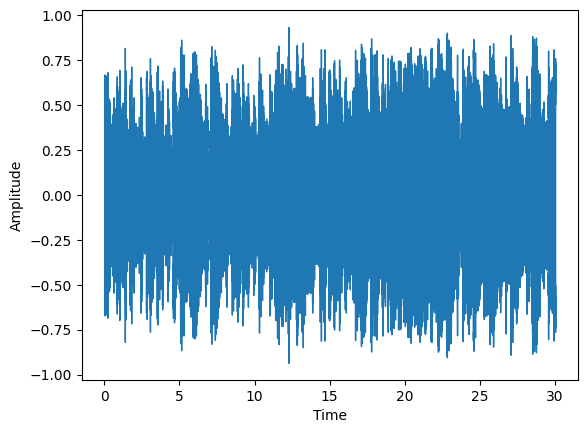

In [ ]:
librosa.display.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

In [ ]:
fft = np.fft.fft(signal)

In [ ]:
magnitude = np.abs(fft)

In [ ]:
frequency = np.linspace(0, sr, len(magnitude))

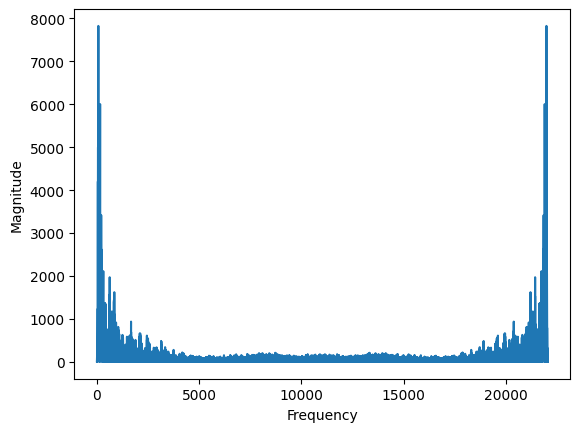

In [ ]:
plt.plot(frequency, magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
left_frequency = frequency[:int(len(frequency)/2)]
left_magnitude = magnitude[:int(len(frequency)/2)]

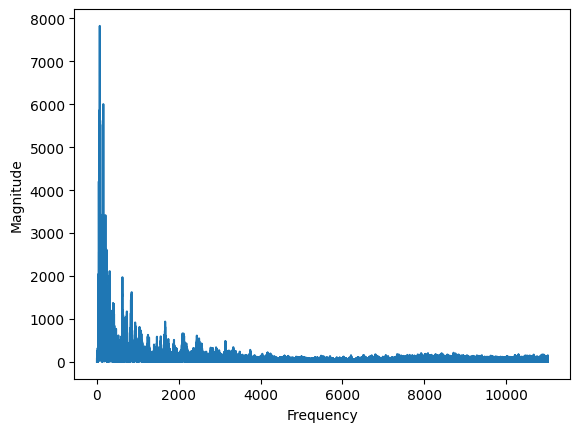

In [ ]:
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
right_frequency = frequency[int(len(frequency)/2):]
right_magnitude = magnitude[int(len(frequency)/2):]

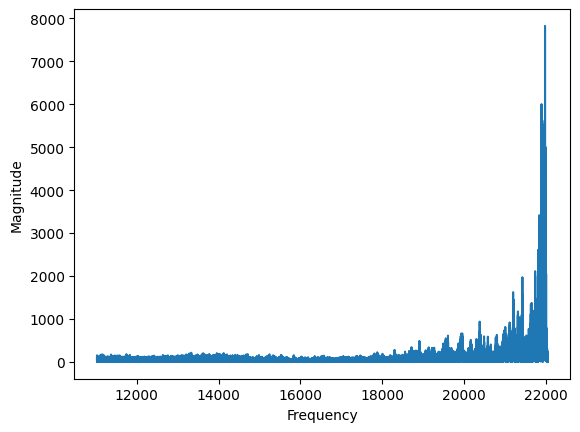

In [ ]:
plt.plot(right_frequency, right_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [ ]:
n_fft=2048 # Number of time for each sample
hop_length = 512 # the amount we slide to the right

In [ ]:
stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)

In [ ]:
spectogram = np.abs(stft)

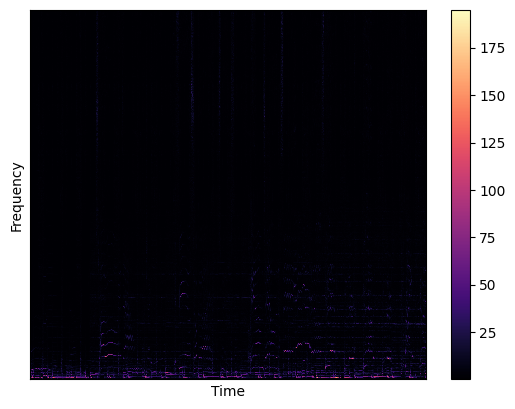

In [ ]:
librosa.display.specshow(spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

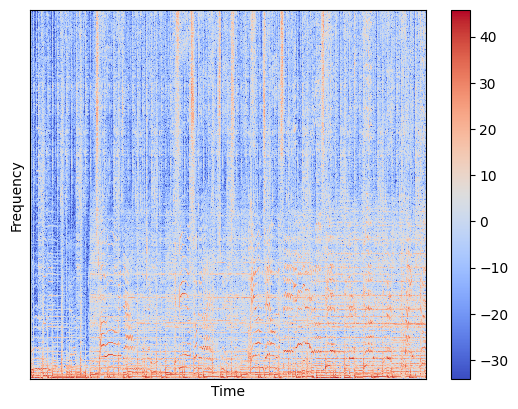

In [ ]:
log_spectogram = librosa.amplitude_to_db(spectogram)
librosa.display.specshow(log_spectogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.show()

In [ ]:
MFFCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

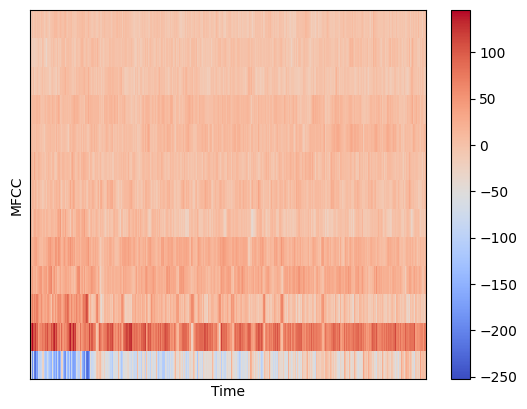

In [ ]:
librosa.display.specshow(MFFCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()

# Création du jeu de données

`num_segments` va diviser chaque piste en plusieurs segments de musique pour augmenter artificiellement le nombre d'exemples de notre jeu de données d'entraînement.

In [ ]:
for i, (dirpath, dirnames, filesnames) in enumerate(os.walk("drive/MyDrive/Music_genre_classification/genres_original/")):

  # ensure that we're not at the root level
  if dirpath != "drive/MyDrive/Music_genre_classification/genres_original/":
    dirpath_components = dirpath.split("/")
    semantic_label = dirpath_components[-1]
    print(semantic_label)

country
disco
metal
blues
jazz
reggae
rock
pop
classical
hiphop


In [ ]:
# sample rate
SAMPLE_RATE = 22050

# Longueur de chaque morceau du jeu de données
DURATION = 30

# durée de chaque segment de chanson
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
  """

  """
  # dictionary to store data
  data = {
      "mapping": [],
      "labels": [],
      "mfcc": []
  }

  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_vectors_per_segment = np.ceil(num_samples_per_segment / hop_length)

  # Loop through all the genres

  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

    # ensure that we're not at the root level
    if dirpath is not dataset_path:

      # save the semantic label
      dirpath_components = dirpath.split("/")
      semantic_label = dirpath_components[-1]
      data["mapping"].append(semantic_label)
      print('\nProcessing {}'.format(semantic_label))

      # process files for a specific genre
      for f in filenames:
        # load the audio file
        file_path = os.path.join(dirpath, f)
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # process segments extracting mfcc and sotring data
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s
          finish_sample = start_sample + num_samples_per_segment

          mfcc = librosa.feature.mfcc(y=signal[start_sample:finish_sample],
                                      sr=sr,
                                      n_fft=n_fft,
                                      n_mfcc=n_mfcc,
                                      hop_length=hop_length)

          mfcc = mfcc.T

          # store mfcc for segment if it has the expected length
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
            data["labels"].append(i-1)
            print("{}, segment:{}".format(file_path, s))

  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)


In [ ]:
#data = save_mfcc(dataset_path="drive/MyDrive/Music_genre_classification/genres_original/",
#          json_path="drive/MyDrive/Music_genre_classification/genres_original/data.json",
#          num_segments=10)

# Deep learning classique

# Créer le générateur

In [ ]:
def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)

    # Convert lists into numpy arrays
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])

    return inputs, targets

In [ ]:
inputs, targets = load_data("drive/MyDrive/Music_genre_classification/genres_original/data.json")

In [ ]:
inputs.shape

(9986, 130, 13)

In [ ]:
targets.shape

(9986,)

In [ ]:
inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs,
                                                                          targets,
                                                                          test_size=0.3)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x_train, y_train):
        self.input = x_train
        self.output = y_train

    def __len__(self):
        return len(self.output)

    def __getitem__(self, idx):
        batch_input = self.input[idx, :, :]
        batch_output = self.output[idx]

        return batch_input, batch_output

In [ ]:
x_training = CustomDataset(torch.from_numpy(np.float32(inputs_train)),
                                 torch.from_numpy(targets_train))

In [ ]:
dataloader_train = torch.utils.data.DataLoader(x_training,
                                                batch_size=32,
                                                shuffle=True)

In [ ]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 130, 13])
torch.Size([32])


In [ ]:
x_testing = CustomDataset(torch.from_numpy(np.float32(inputs_test)),
                                 torch.from_numpy(targets_test))

In [ ]:
dataloader_test = torch.utils.data.DataLoader(x_testing,
                                                batch_size=32,
                                                shuffle=True)

In [ ]:
for x, y in dataloader_test:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 130, 13])
torch.Size([32])


# Entraînement du modèle

## Fonction d'entraînement

In [ ]:
def number_of_good_prediction(prediction:float, target:int):
  one_hot_prediction = np.argmax(prediction, axis=1)
  return np.sum(one_hot_prediction == target)

In [ ]:
def step(model:torch.nn.Sequential,
         opt:torch.optim,
         criterion:torch.nn.modules.loss,
         x_train:torch.Tensor,
         y_train:torch.Tensor,
         metric_function)->tuple:
  """
  Executes a single training step for a PyTorch model.
  This function performs a forward pass to compute the model's predictions, calculates
  the loss between predictions and actual target values, computes gradients for each
  model parameter, and updates the parameters using the optimizer.

  Args:
      model (torch.nn.Sequential): The PyTorch model to train.
      optimizer (torch.optim.Optimizer): Optimizer used to update the model's parameters.
      criterion (torch.nn.modules.loss._Loss): Loss function used to compute the error.
      x_train (torch.Tensor): Input training data (features).
      y_train (torch.Tensor): Ground truth labels or target values for the training data.
  Returns:
      tuple: The updated model and the computed loss for the current step.
  """

  # Réinitialisez les gradients d'optimizer à zéro avec la méthode 'zero_grad'
  opt.zero_grad()

  # Calculez les prédiction sur le jeu d'entraînement avec la méthode 'froward'
  prediction = model.forward(x_train)

  # Calculez l'erreur de prédiction avec 'criterion'
  loss = criterion(prediction, y_train)

  performance = metric_function(prediction.detach().numpy(), y_train.detach().numpy())

  # Calculez les gradients avec la méthode 'backward'
  loss.backward()

  # Mettre à jour les paramètres du modèle avec la méthode 'step'
  opt.step()

  return model, loss, performance

In [ ]:
def fit(model, optimizer, criterion, epoch, trainloader, testloader, metric_function):
    epoch = epoch
    history_train_loss = []
    history_test_loss = []
    history_train_metrics = []
    history_test_metrics = []

    for e in range(epoch) :

      train_loss_batch = 0
      test_loss_batch = 0
      train_metric_batch = 0
      test_metric_batch = 0

      for images, labels in trainloader:

        # mise à jour des poids avec la fonction 'step'
        model, train_loss, train_performance = step(model, optimizer, criterion, images, labels, metric_function)

        train_loss_batch += train_loss.detach().numpy()

        train_metric_batch += train_performance

      for images, labels in testloader:

        prediction = model.forward(images)

        test_loss = criterion(prediction, labels)

        test_metric_batch += metric_function(prediction.detach().numpy(), labels.detach().numpy())

        test_loss_batch += test_loss.detach().numpy()

      train_loss_batch /= len(trainloader.sampler)
      test_loss_batch /= len(testloader.sampler)

      train_metric_batch /= len(trainloader.sampler)
      test_metric_batch /= len(testloader.sampler)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_loss = np.append(history_train_loss, train_loss_batch)
      history_test_loss = np.append(history_test_loss, test_loss_batch)

      # Sauvegarde des coûts d'entraînement avec append
      history_train_metrics = np.append(history_train_metrics, train_metric_batch)
      history_test_metrics = np.append(history_test_metrics, test_metric_batch)

      print(f'epoch : {e}/{epoch}')
      print('train_loss : '+str(np.squeeze(train_loss_batch))+ ' test_loss : '+str(np.squeeze(test_loss_batch)))
      print('train_metric : '+str(np.squeeze(train_metric_batch))+ ' test_metric : '+str(np.squeeze(test_metric_batch)))
      print('-------------------------------------------------------------------------------------------------')

    return model, history_train_loss, history_test_loss, history_train_metrics, history_test_metrics


Création de l'architecture

In [ ]:
model_deep = torch.nn.Sequential(torch.nn.Flatten(),
                                 torch.nn.Linear(in_features=130*13, out_features=512),
                                 torch.nn.ReLU(),
                                 torch.nn.Linear(in_features=512, out_features=256),
                                 torch.nn.ReLU(),
                                 torch.nn.Linear(in_features=256, out_features=10),
                                 torch.nn.LogSoftmax(dim=1))

In [ ]:
summary(model_deep, (130, 13), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 1690]               0
            Linear-2                  [-1, 512]         865,792
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                   [-1, 10]           2,570
        LogSoftmax-7                   [-1, 10]               0
Total params: 999,690
Trainable params: 999,690
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 3.81
Estimated Total Size (MB): 3.84
----------------------------------------------------------------


In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_deep.parameters(), lr=0.001)

In [ ]:
epoch = 10

In [ ]:
model, history_train_loss_deep, history_test_loss_deep, history_train_metrics_deep, history_test_metrics_deep = fit(model_deep,
                                                   optimizer,
                                                   criterion,
                                                   epoch,
                                                   dataloader_train,
                                                   dataloader_test,
                                                   number_of_good_prediction)

epoch : 0/10
train_loss : 0.0923940633158486 test_loss : 0.04495219176060686
train_metric : 0.39842632331902716 test_metric : 0.47897196261682246
-------------------------------------------------------------------------------------------------
epoch : 1/10
train_loss : 0.04317986432233764 test_loss : 0.04333816343378798
train_metric : 0.5028612303290415 test_metric : 0.5166889185580774
-------------------------------------------------------------------------------------------------
epoch : 2/10
train_loss : 0.0384012093274549 test_loss : 0.04584646155343992
train_metric : 0.5669527896995709 test_metric : 0.5146862483311081
-------------------------------------------------------------------------------------------------
epoch : 3/10
train_loss : 0.03486278866323108 test_loss : 0.043674776626524525
train_metric : 0.6052932761087267 test_metric : 0.5283711615487316
-------------------------------------------------------------------------------------------------
epoch : 4/10
train_loss : 0

# CNN

In [ ]:
x_training = CustomDataset(torch.from_numpy(np.float32(np.expand_dims(inputs_train, axis=1))),
                                 torch.from_numpy(targets_train))

In [ ]:
dataloader_train_cnn = torch.utils.data.DataLoader(x_training,
                                                batch_size=32,
                                                shuffle=True)

In [ ]:
for x, y in dataloader_train_cnn:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 130, 13])
torch.Size([32])


In [ ]:
x_testing = CustomDataset(torch.from_numpy(np.float32(np.expand_dims(inputs_test, axis=1))),
                                 torch.from_numpy(targets_test))

In [ ]:
dataloader_test_cnn = torch.utils.data.DataLoader(x_testing,
                                                batch_size=32,
                                                shuffle=True)

In [ ]:
for x, y in dataloader_test_cnn:
  print(x.shape)
  print(y.shape)
  break

torch.Size([32, 1, 130, 13])
torch.Size([32])


In [ ]:
model_cnn = torch.nn.Sequential(
                                 torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
                                 torch.nn.ReLU(),
                                 torch.nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
                                 torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
                                 torch.nn.ReLU(),
                                 torch.nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True),
                                 torch.nn.Flatten(),
                                 torch.nn.Linear(in_features=3968, out_features=64),
                                 torch.nn.ReLU(),
                                 #torch.nn.Dropout(0.2),
                                 torch.nn.Linear(in_features=64, out_features=10),
                                 torch.nn.LogSoftmax(dim=1))

In [ ]:
summary(model_cnn, (1, 130, 13), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 32, 128, 11]             320
              ReLU-2          [-1, 32, 128, 11]               0
         MaxPool2d-3            [-1, 32, 64, 6]               0
            Conv2d-4            [-1, 64, 62, 4]          18,496
              ReLU-5            [-1, 64, 62, 4]               0
         MaxPool2d-6            [-1, 64, 31, 2]               0
           Flatten-7                 [-1, 3968]               0
            Linear-8                   [-1, 64]         254,016
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
       LogSoftmax-11                   [-1, 10]               0
Total params: 273,482
Trainable params: 273,482
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)

In [ ]:
model, history_train_loss_cnn, history_test_loss_cnn, history_train_metrics_cnn, history_test_metrics_cnn = fit(model_cnn,
                                                   optimizer,
                                                   criterion,
                                                   epoch,
                                                   dataloader_train_cnn,
                                                   dataloader_test_cnn,
                                                   number_of_good_prediction)

epoch : 0/10
train_loss : 0.061047727475009424 test_loss : 0.04874958509755867
train_metric : 0.33419170243204577 test_metric : 0.43391188251001334
-------------------------------------------------------------------------------------------------
epoch : 1/10
train_loss : 0.04249138263332656 test_loss : 0.04163836680840109
train_metric : 0.5015736766809729 test_metric : 0.5100133511348465
-------------------------------------------------------------------------------------------------
epoch : 2/10
train_loss : 0.037695984480548145 test_loss : 0.038923794222132706
train_metric : 0.5586552217453505 test_metric : 0.5644192256341789
-------------------------------------------------------------------------------------------------
epoch : 3/10
train_loss : 0.033592086655217006 test_loss : 0.04130151678866474
train_metric : 0.6131616595135908 test_metric : 0.5357142857142857
-------------------------------------------------------------------------------------------------
epoch : 4/10
train_los

# RNN

In [ ]:
# Définir le modèle RNN
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Couche RNN
        self.rnn = torch.nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Couche entièrement connectée pour la sortie
        self.fc1 = torch.nn.Linear(hidden_size, hidden_size)

        self.fc2 = torch.nn.Linear(hidden_size, output_size)

        self.softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x):
        # Initialiser l'état caché avec des zéros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        #c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Passer les données dans la couche RNN
        out, h_n = self.rnn(x, h0)

        last = self.fc1(out[:, -1, :])

        last = self.fc2(last)

        proba = self.softmax(last)
        return proba

In [ ]:
# Définir les dimensions d'entrée et de sortie
input_size = 13
hidden_size = 128
num_layers = 1
output_size = 10

# Initialiser le modèle
model_rnn = RNNModel(input_size, hidden_size, num_layers, output_size)

In [ ]:
summary(model_rnn, input_size=(130, input_size), device='cpu')

In [ ]:
for x, y in dataloader_train:
  print(x.shape)
  print(y.shape)
  break

In [ ]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model_rnn.parameters(), lr=0.001)

In [ ]:
model, history_train_loss_rnn, history_test_loss_rnn, history_train_metrics_rnn, history_test_metrics_rnn = fit(model_rnn,
                                                                                                                optimizer,
                                                                                                                criterion,
                                                                                                                epoch,
                                                                                                                dataloader_train,
                                                                                                                dataloader_test,
                                                                                                                number_of_good_prediction)

epoch : 0/10
train_loss : 0.058152550979063064 test_loss : 0.055774753338822695
train_metric : 0.33533619456366237 test_metric : 0.3531375166889186
-------------------------------------------------------------------------------------------------
epoch : 1/10
train_loss : 0.05308754623192063 test_loss : 0.05437022570933455
train_metric : 0.3888412017167382 test_metric : 0.38584779706275035
-------------------------------------------------------------------------------------------------
epoch : 2/10
train_loss : 0.051302933778203434 test_loss : 0.05281380005926888
train_metric : 0.41201716738197425 test_metric : 0.3951935914552737
-------------------------------------------------------------------------------------------------
epoch : 3/10
train_loss : 0.04992627882650482 test_loss : 0.05273325456796246
train_metric : 0.430758226037196 test_metric : 0.3968624833110814
-------------------------------------------------------------------------------------------------
epoch : 4/10
train_loss

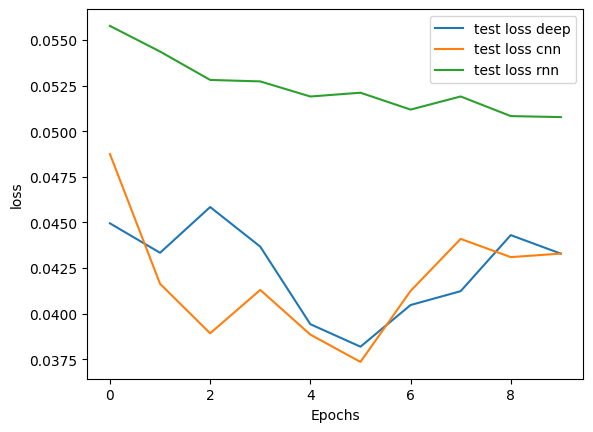

In [ ]:
#plt.plot(np.arange(epoch), history_train_loss_deep, label='train loss deep')
plt.plot(np.arange(epoch), history_test_loss_deep, label='test loss deep')
#plt.plot(np.arange(epoch), history_train_loss_cnn, label='train loss cnn')
plt.plot(np.arange(epoch), history_test_loss_cnn, label='test loss cnn')
#plt.plot(np.arange(epoch), history_train_loss_rnn, label='train loss rnn')
plt.plot(np.arange(epoch), history_test_loss_rnn, label='test loss rnn')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend(loc='upper left')
plt.legend()
plt.show()

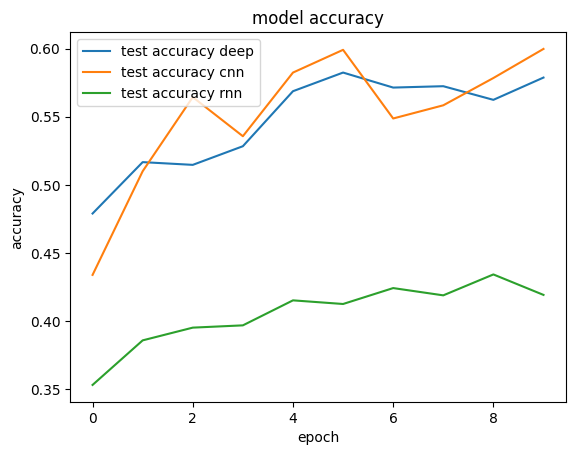

In [ ]:
#plt.plot(history_train_metrics_deep, label='train accuracy deep')
plt.plot(history_test_metrics_deep, label='test accuracy deep')
#plt.plot(history_train_metrics_cnn, label='train accuracy cnn')
plt.plot(history_test_metrics_cnn, label='test accuracy cnn')
#plt.plot(history_train_metrics_rnn, label='train accuracy rnn')
plt.plot(history_test_metrics_rnn, label='test accuracy rnn')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper left')
plt.show()